# Air Traffic Model Prototyping

This notebook defines a prototype air traffic model.

This model makes the following assumptions:
- A crew is available when each aircraft wants to depart (i.e. crew factors do not affect schedule),
- Each airport has one runway shared by arrivals and departures, and no limit to the number of aircraft who can be waiting to use it, so they are modeled as M/M/1/inf/FIFO queues

In [35]:
# Import and setup
import pprint
import logging
import os
from typing import Optional
import copy
from dataclasses import dataclass

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(level=logging.DEBUG)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [56]:
# Define some data types that will be useful
TailNumber = str
AirportCode = str
Time = torch.tensor

@dataclass
class ItineraryItem:
    origin: AirportCode
    destination: AirportCode
    scheduled_departure_time: Time
    scheduled_arrival_time: Time
    actual_departure_time: Optional[Time] = None
    actual_arrival_time: Optional[Time] = None

@dataclass
class Aircraft:
    tail_number: TailNumber
    itinerary: list[ItineraryItem]
    _current_itinerary_item_idx: int = 0

    @property
    def current_leg(self) -> ItineraryItem:
        return self.itinerary[self._current_itinerary_item_idx]
    
    @property
    def next_leg(self) -> ItineraryItem:
        if self._current_itinerary_item_idx == len(self.itinerary) - 1:
            return None
        else:            
            return self.itinerary[self._current_itinerary_item_idx + 1]

    def advance_itinerary(self) -> None:
        # Only advance if we're not on the last leg
        if self._current_itinerary_item_idx < len(self.itinerary) - 1:
            self._current_itinerary_item_idx += 1

    def __str__(self) -> str:
        return (
            f"{self.tail_number}_"
            f"{self.current_leg.origin}->{self.current_leg.destination}"
        )

@dataclass
class Airport:
    code: AirportCode
    runway_queue: list[list[Aircraft, bool, Time, Time, Optional[Time]]] # aircraft, departing/arriving, queue start time, total waiting time, assigned service time
    parked_aircraft: list[tuple[Aircraft, Time]]  # aircraft, earliest departure time

@dataclass
class State:
    in_flight_aircraft: list[tuple[Aircraft, Time]]  # aircraft, earliest arrival time
    airports: dict[AirportCode, Airport]

In [53]:
# Parse the provided data into our custom data structures
def parse_schedule_row(schedule_row: tuple) -> ItineraryItem:
    """
    Parse a row of the schedule into an ItineraryItem object.

    Args:
        schedule_row: a tuple of the following items
            - origin_airport
            - destination_airport
            - scheduled_departure_time
            - scheduled_arrival_time
            - actual_departure_time
            - actual_arrival_time
    """
    (
        origin_airport,
        destination_airport,
        scheduled_departure_time,
        scheduled_arrival_time,
        actual_departure_time,
        actual_arrival_time,
    ) = schedule_row

    return ItineraryItem(
        origin=origin_airport,
        destination=destination_airport,
        scheduled_departure_time=scheduled_departure_time,
        scheduled_arrival_time=scheduled_arrival_time,
        actual_departure_time=actual_departure_time,
        actual_arrival_time=actual_arrival_time,
    )


def parse_schedule(schedule_df: pd.DataFrame) -> State:
    """Parse a pandas dataframe for a schedule into a state object.

    Args:
        schedule_df: A pandas dataframe with the following columns:
            tail_number: The tail number of the aircraft
            origin_airport: The airport code of the origin airport
            destination_airport: The airport code of the destination airport
            scheduled_departure_time: The scheduled departure time
            scheduled_arrival_time: The scheduled arrival time
            actual_departure_time: The actual departure time
            actual_arrival_time: The actual arrival time
    """
    # Create an airport object for each airport in the schedule
    airport_codes = pd.concat(
        [schedule_df["origin_airport"], schedule_df["destination_airport"]]
    ).unique()
    airports = {
        airport_code: Airport(code=airport_code, runway_queue=[], parked_aircraft=[])
        for airport_code in airport_codes
    }

    # Construct objects for each aircraft, extracting their itineraries, and parking
    # them in their origin airports (assuming no turnaround time for the first flight of
    # the day)
    for tail_number in schedule_df["tail_number"].unique():
        # Get the itinerary for this aircraft
        itinerary_df = schedule_df[
            schedule_df["tail_number"] == tail_number
        ].sort_values(by="scheduled_departure_time")
        itinerary_items = [
            parse_schedule_row(row)
            for row in zip(
                itinerary_df["origin_airport"],
                itinerary_df["destination_airport"],
                itinerary_df["scheduled_departure_time"],
                itinerary_df["scheduled_arrival_time"],
                itinerary_df["actual_departure_time"],
                itinerary_df["actual_arrival_time"],
            )
        ]

        # Create the aircraft object and park it at the first airport
        aircraft = Aircraft(tail_number=tail_number, itinerary=itinerary_items)
        origin_airport = airports[itinerary_items[0].origin]
        origin_airport.parked_aircraft.append(
            (aircraft, itinerary_items[0].scheduled_departure_time)
        )

    # No aircraft start in flight
    in_flight_aircraft = []

    return State(in_flight_aircraft=in_flight_aircraft, airports=airports)

In [58]:
# Define a simple schedule that sends the aircraft from airport 0 to airport 1 and back
# Time is defined in hours from the start of the simulation
schedule = pd.DataFrame({
    "tail_number": ["N1", "N1"],
    "origin_airport": ["A1", "A2"],
    "destination_airport": ["A2", "A1"],
    "scheduled_departure_time": [0.0, 1.5],
    "scheduled_arrival_time": [1.0, 3.0],
    "actual_departure_time": [None, None],
    "actual_arrival_time": [None, None],
})

state = parse_schedule(schedule)

/tmp/ipykernel_3422231/3249808403.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist.Exponential(torch.tensor(1.0 / airport_service_times[airport.code])),
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


Sampling service time 0.151164710521698 with rate 6.532366752624512
Sampling service time 0.024991368874907494 with rate 5.522851943969727
Sampling service time 0.17981043457984924 with rate 5.522851943969727
Sampling service time 0.11915569752454758 with rate 6.532366752624512


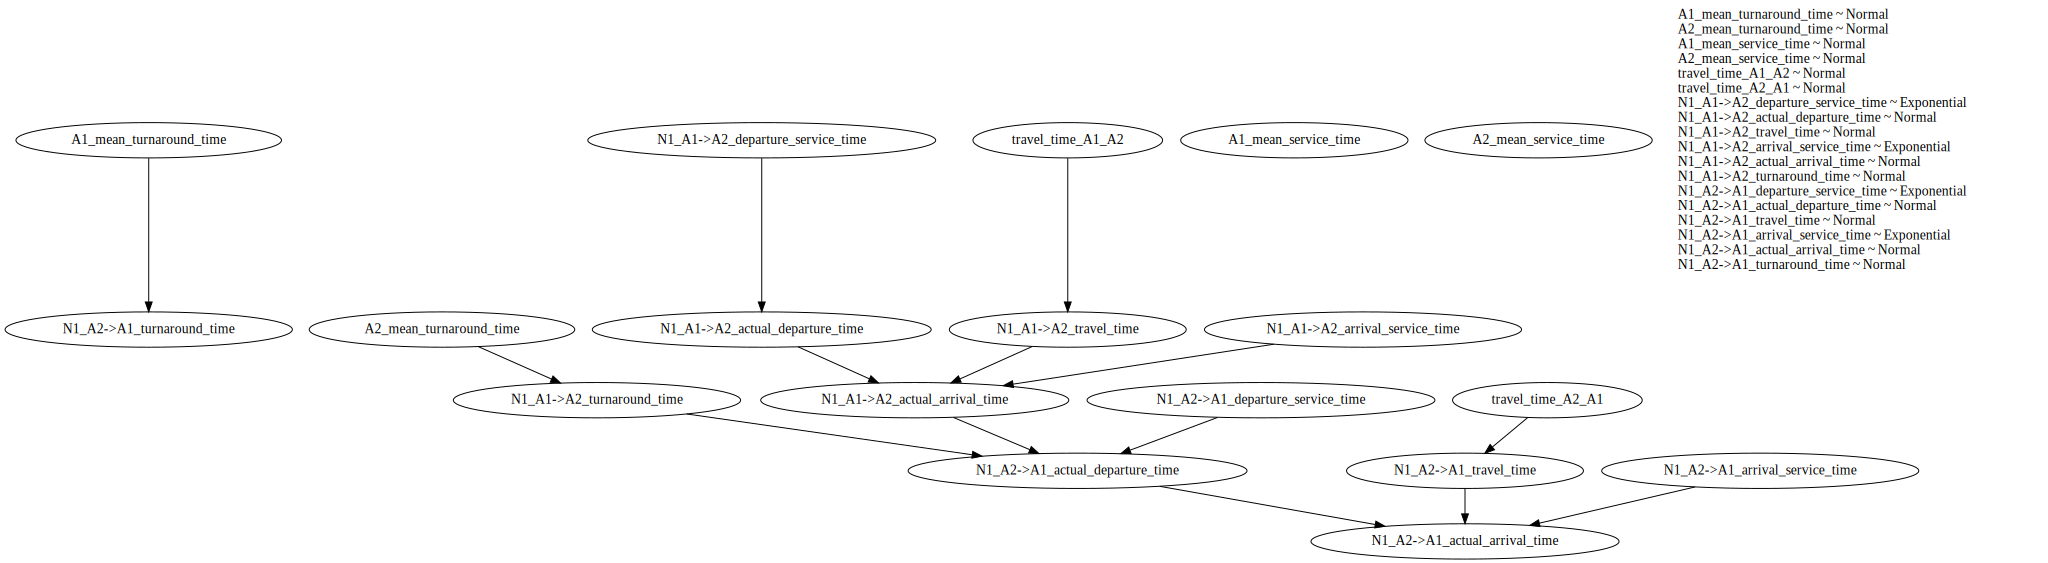

In [59]:
def air_traffic_network_model(state: State, T: float = 24.0, delta_t: float = 0.1):
    """
    Simulate the behavior of one aircraft flying between two airports.

    Data should be sorted in order of increasing scheduled departure time.

    Args:
        state: the starting state of the simulation
        T: the duration of the simulation, in hours
        delta_t: the time resolution of the simulation, in hours
    """
    # Define parameters used by the simulation
    runway_use_time_standard_deviation = 1.0 / 60  # 1 minute
    travel_time_fractional_variation = 0.05  # 5% variation in travel time
    turnaround_time_fractional_variation = 0.05  # 5% variation in turnaround time

    # Sample latent variables for airports
    airport_codes = state.airports.keys()
    airport_turnaround_times = {
        code: pyro.sample(f"{code}_mean_turnaround_time", dist.Normal(0.75, 0.25))
        for code in airport_codes
    }
    airport_service_times = {
        code: pyro.sample(f"{code}_mean_service_time", dist.Normal(9.0 / 60, 3.0 / 60))
        for code in airport_codes
    }
    travel_times = {
        (origin, destination): pyro.sample(
            f"travel_time_{origin}_{destination}", dist.Normal(1.0, 0.25)
        )
        for origin in airport_codes
        for destination in airport_codes
        if origin != destination
    }

    # Make a copy of the state so we don't change the input state
    state = copy.deepcopy(state)

    # Simulate the movement of aircraft within the system for a fixed period of time
    t = 0.0
    for _ in pyro.markov(range(int(T // delta_t))):
        # Update the current time
        t += delta_t

        # Parked aircraft that are ready to depart move to the runway service queue.
        # An aircraft is ready to depart if the current time is greater than its
        # earliest possible departure time.
        for airport in state.airports.values():
            new_parked_aircraft = []
            for aircraft, earliest_departure_time in airport.parked_aircraft:
                if t >= earliest_departure_time:
                    # logging.debug(f"(t={t:.2f}) {aircraft} is ready to depart from {airport.code}; moving to queue")
                    # TODO can queue items be a dataclass?
                    airport.runway_queue.append(
                        [
                            aircraft,
                            True,  # departing
                            earliest_departure_time, # queue start time
                            0.0, # no wait time yet
                            None,  # no service time yet
                        ]
                    )
                else:
                    new_parked_aircraft.append((aircraft, earliest_departure_time))

            airport.parked_aircraft = new_parked_aircraft

        # In-flight aircraft that are ready to arrive move to the service queue.
        # An aircraft is ready to arrive if the current time is greater than its
        # earliest possible arrival time.
        new_in_flight_aircraft = []
        for aircraft, earliest_arrival_time in state.in_flight_aircraft:
            if t >= earliest_arrival_time:
                # logging.debug(f"(t={t:.2f}) {aircraft} is ready to arrive at {aircraft.current_leg.destination}; moving to queue")
                destination_airport = aircraft.current_leg.destination
                state.airports[destination_airport].runway_queue.append(
                    [
                        aircraft,
                        False,  # arriving
                        earliest_arrival_time, # queue start time
                        0.0, # no wait time yet
                        None,  # no service time yet
                    ]
                )
            else:
                new_in_flight_aircraft.append((aircraft, earliest_arrival_time))

        state.in_flight_aircraft = new_in_flight_aircraft

        # Aircraft in the runway queue that are ready to be serviced are serviced.
        for airport in state.airports.values():
            # Process the aircraft at the start of the queue as long as it's not waiting
            # past the current time.

            # TODO this is a lot of nested loops/conditionals. Consider factoring into
            # smaller functions.
            while airport.runway_queue and (airport.runway_queue[0][4] is None or t >= airport.runway_queue[0][4]):
                # If the aircraft at the front of the queue does not have a service time
                # yet, sample one from the airport's service time distribution. If we have
                # observed the actual arrival/departure time, use that instead.
                if airport.runway_queue[0][4] is None:
                    aircraft, departing, queue_start_time, total_wait_time, _ = airport.runway_queue[0]

                    var_name = str(aircraft)
                    if departing:
                        var_name += "_departure_service_time"
                    else:
                        var_name += "_arrival_service_time"

                    service_time = pyro.sample(
                        var_name,
                        dist.Exponential(torch.tensor(1.0 / airport_service_times[airport.code])),
                    )
                    # TODO fix this tensor thing.
                    print(f"Sampling service time {service_time} with rate {1.0 / airport_service_times[airport.code]}")
                    airport.runway_queue[0] = [aircraft, departing, queue_start_time, total_wait_time, t + service_time]

                    # Add the service time to the wait time of every aircraft in the queue
                    for i in range(len(airport.runway_queue)):
                        airport.runway_queue[i][3] += service_time

                    # logging.debug(f"(t={t:.2f}) {aircraft} is at the front of the queue at {airport.code}; assigning service time {t + service_time:.2f}")

                # If the aircraft at the front of the queue has been serviced, it takes off
                # or lands.
                if t >= airport.runway_queue[0][4]:
                    aircraft, departing, queue_start_time, total_wait_time, service_time = airport.runway_queue.pop(0)

                    # logging.debug(f"(t={t:.2f}) {aircraft} is ready to be served at {airport.code}")

                    var_name = str(aircraft)
                    if departing:
                        # The aircraft takes off.

                        # Record its actual departure time. If we have observed the actual
                        # departure time, use that instead to condition the model.
                        aircraft.current_leg.actual_departure_time = pyro.sample(
                            var_name + "_actual_departure_time",
                            dist.Normal(
                                queue_start_time + total_wait_time, runway_use_time_standard_deviation
                            ),
                            obs=aircraft.current_leg.actual_departure_time,
                        )

                        # Move the aircraft to the in-flight list, sampling a travel time
                        # from the travel time distribution.
                        nominal_travel_time = travel_times[
                            aircraft.current_leg.origin,
                            aircraft.current_leg.destination,
                        ]
                        travel_time = pyro.sample(
                            var_name + "_travel_time",
                            dist.Normal(
                                nominal_travel_time,
                                nominal_travel_time * travel_time_fractional_variation,
                            ),
                        )
                        state.in_flight_aircraft.append((aircraft, aircraft.current_leg.actual_departure_time + travel_time))

                        # logging.debug(f"\t{aircraft} assigned travel time {travel_time:.2f}; will arrive at {aircraft.current_leg.destination} at {t + travel_time:.2f}")
                    else:
                        # The aircraft lands.

                        # Record its actual arrival time. If we have observed the actual
                        # arrival time, use that instead to condition the model.
                        aircraft.current_leg.actual_arrival_time = (
                            pyro.sample(
                                var_name + "_actual_arrival_time",
                                dist.Normal(
                                    queue_start_time + total_wait_time, runway_use_time_standard_deviation
                                ),
                                obs=aircraft.current_leg.actual_arrival_time,
                            )
                        )

                        # Sample a random turnaround time from the distribution for the
                        # destination airport.
                        destination = aircraft.current_leg.destination
                        nominal_turnaround_time = airport_turnaround_times[destination]
                        turnaround_time = pyro.sample(
                            var_name + "_turnaround_time",
                            dist.Normal(
                                nominal_turnaround_time,
                                nominal_turnaround_time
                                * turnaround_time_fractional_variation,
                            ),
                        )
                        # The earliest the aircraft can depart is the current time plus the
                        # turnaround time or its next scheduled departure time, whichever is
                        # later.
                        next_scheduled_departure_time = (
                            aircraft.next_leg.scheduled_departure_time
                            if aircraft.next_leg is not None
                            else float("inf")
                        )
                        earliest_departure_time = max(
                            aircraft.current_leg.actual_arrival_time + turnaround_time, next_scheduled_departure_time
                        )
                        state.airports[destination].parked_aircraft.append(
                            (aircraft, earliest_departure_time)
                        )

                        # logging.debug(f"\t{aircraft} assigned turnaround {turnaround_time:.2f}; will depart at {earliest_departure_time:.2f}")

                        # Mark the aircraft as being on the next leg of its itinerary
                        aircraft.advance_itinerary()

    # Once we're done, return the state (this will include the actual arrival/departure
    # times for each aircraft)
    return state

pyro.render_model(air_traffic_network_model, model_args=(state, 5.0, 0.1), render_params=True, render_distributions=True)

In [27]:
simulated_state = air_traffic_network_model(state, 5.0, 0.1)
pprint.pprint(simulated_state)

State(in_flight_aircraft=[],
      airports={'A1': Airport(code='A1',
                              runway_queue=[],
                              parked_aircraft=[(Aircraft(tail_number='N1',
                                                         itinerary=[ItineraryItem(origin='A1',
                                                                                  destination='A2',
                                                                                  scheduled_departure_time=0.0,
                                                                                  scheduled_arrival_time=1.0,
                                                                                  actual_departure_time=tensor(0.6993),
                                                                                  actual_arrival_time=tensor(2.1631)),
                                                                    ItineraryItem(origin='A2',
                                                         